## After running semgent_into_1min.ipynb, run this code to detect songs. It will:
1) Apply a bandpass filter to only pay attention to biologically relevant frequencies (freuqencies found in canary song)
2) Sum across the biologically-relevant frequencies to get their total amplitudes at each time in the song
3) Smooth the summed amplitudes
4) Apply a threshold to the summed amplitudes
5) Output a spectrogram of the recording and 

## Apply a bandpass filter and sum across those frequencies

The screen resolution in inches is: 15.12x9.82


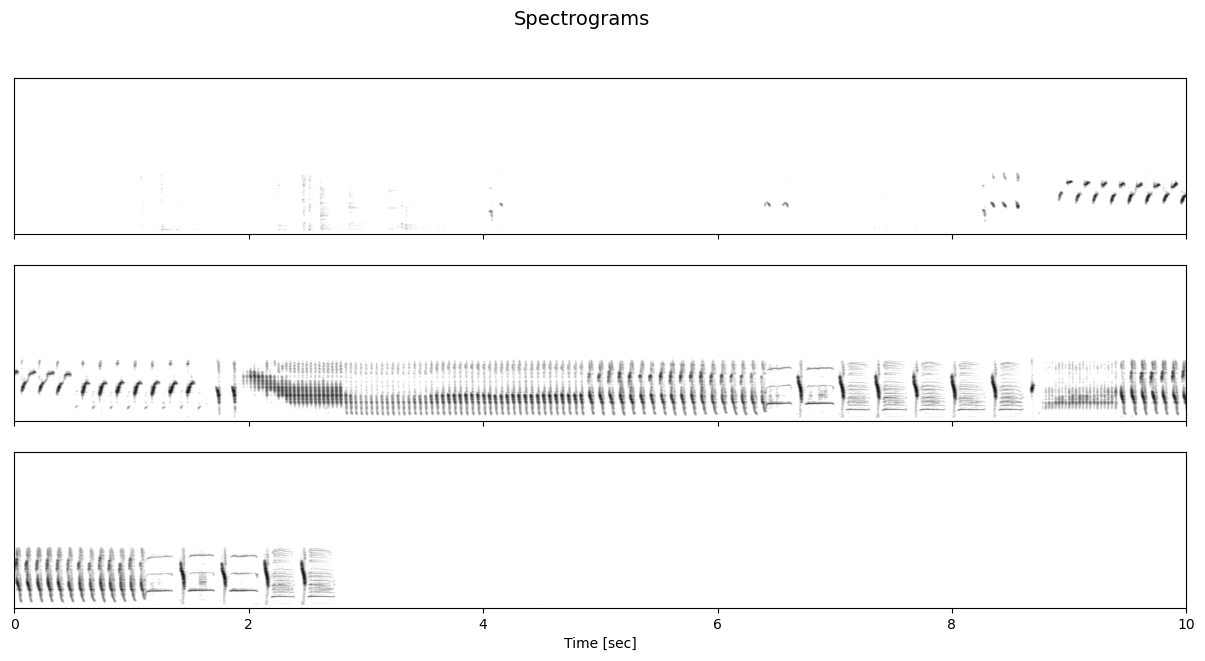

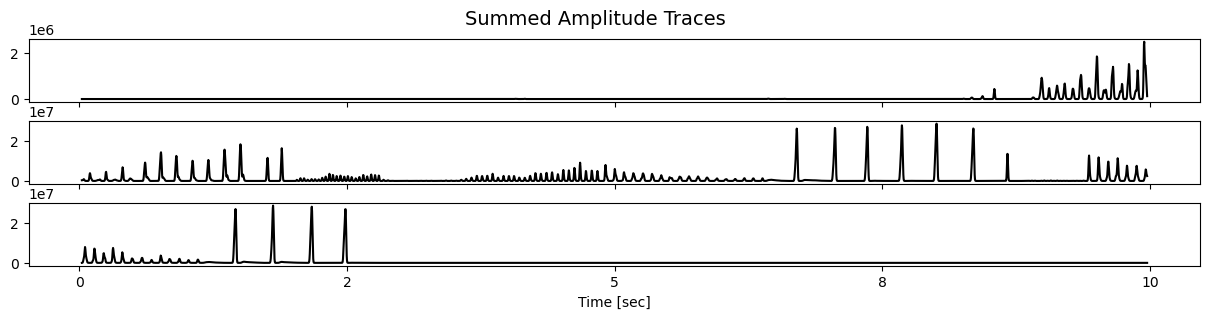

In [34]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            # Log normalize
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Plot spectrogram
            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Plot summed amplitude trace ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)

            axs_sum[i].plot(t, amplitude_trace, color='black')
            #axs_sum[i].set_ylabel('Sum\nAmplitude', fontsize=8)

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                num_ticks = 5
                tick_positions = np.linspace(0, segment_duration, num_ticks)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])

            else:
                axs_sum[i].set_xticks([])

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle('Summed Amplitude Traces', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path)

# Test out different methods for smoothing the amplitude trace

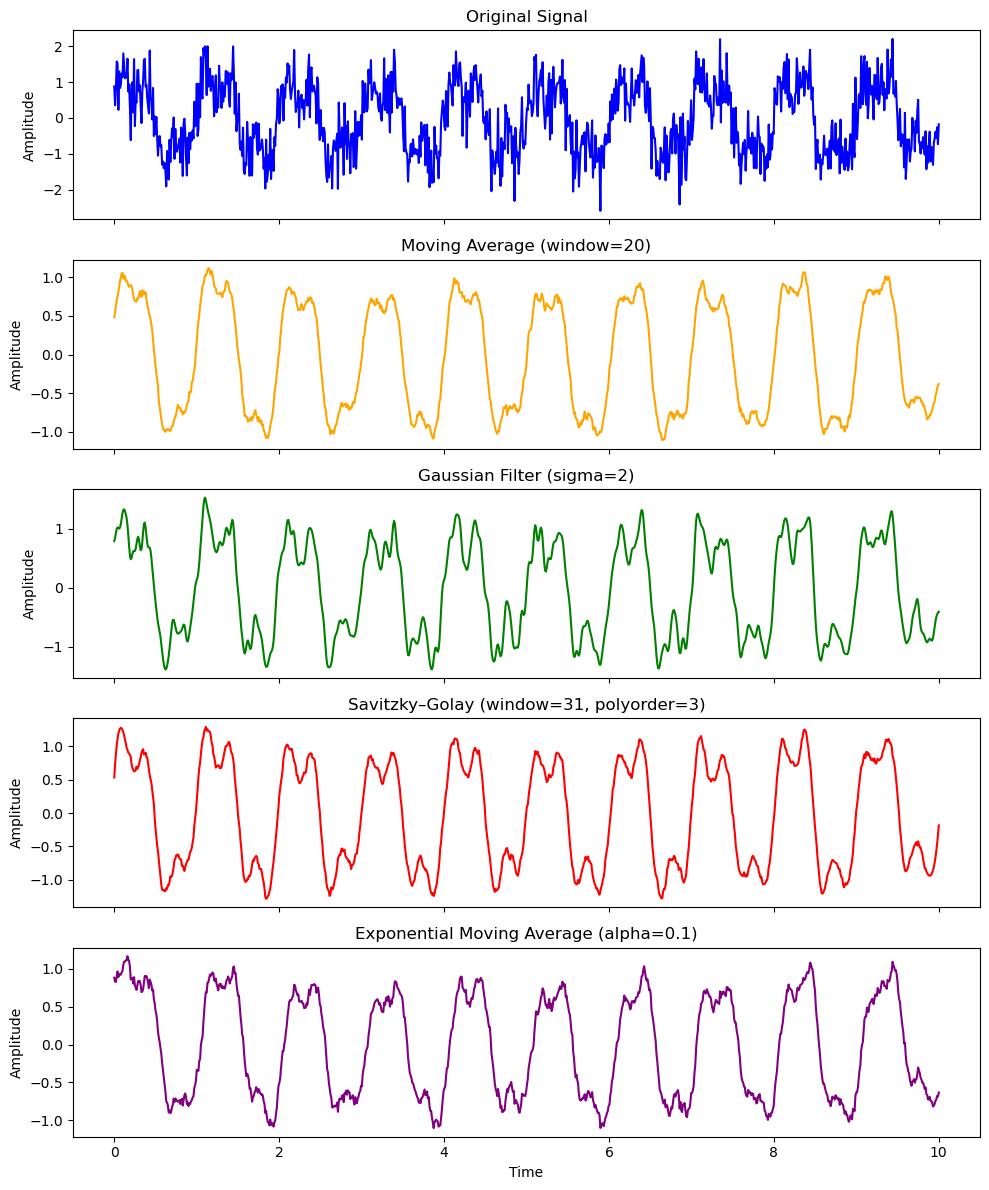

In [9]:
import numpy as np
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

def moving_average(x, window_size):
    """
    Compute the moving average of a 1D array x using a given window size.
    Returns an array of the same length as x.
    """
    if window_size < 1:
        raise ValueError("window_size must be at least 1")
    # Convolve with a window of given size
    window = np.ones(int(window_size)) / float(window_size)
    # Use 'same' mode to get an output of the same length as input
    return np.convolve(x, window, mode='same')

def gaussian_smooth(x, sigma):
    """
    Smooth the 1D array x using a Gaussian filter with standard deviation sigma.
    """
    return gaussian_filter1d(x, sigma)

def savgol_smooth(x, window_length, polyorder):
    """
    Smooth the 1D array x using a Savitzky–Golay filter with given window length and polynomial order.
    """
    return savgol_filter(x, window_length, polyorder)

def exponential_moving_average(x, alpha):
    """
    Compute the exponential moving average of 1D array x with smoothing factor alpha (0 < alpha <= 1).
    """
    if not 0 < alpha <= 1:
        raise ValueError("alpha must be between 0 and 1")
    ema = np.zeros_like(x)
    ema[0] = x[0]  # initialize EMA with first value
    for i in range(1, len(x)):
        ema[i] = alpha * x[i] + (1 - alpha) * ema[i-1]
    return ema

# Generate a synthetic noisy 1D signal (sine waves + noise)
np.random.seed(0)  # for reproducibility
t = np.linspace(0, 10, 1000)  # 0 to 10 (arbitrary units), 1000 samples
signal = np.sin(2 * np.pi * 1.0 * t) + 0.5 * np.sin(2 * np.pi * 3.0 * t)  # two sine waves
signal += 0.5 * np.random.normal(size=t.shape)  # add Gaussian noise

# Apply smoothing techniques
smoothed_ma = moving_average(signal, window_size=20)
smoothed_gauss = gaussian_smooth(signal, sigma=2)
smoothed_sg = savgol_smooth(signal, window_length=31, polyorder=3)
smoothed_ema = exponential_moving_average(signal, alpha=0.1)

# Plot original and smoothed signals in separate subplots
fig, axs = plt.subplots(5, 1, figsize=(10, 12), sharex=True)
axs[0].plot(t, signal, color='blue')
axs[0].set_title("Original Signal")
axs[0].set_ylabel("Amplitude")

axs[1].plot(t, smoothed_ma, color='orange')
axs[1].set_title("Moving Average (window=20)")
axs[1].set_ylabel("Amplitude")

axs[2].plot(t, smoothed_gauss, color='green')
axs[2].set_title("Gaussian Filter (sigma=2)")
axs[2].set_ylabel("Amplitude")

axs[3].plot(t, smoothed_sg, color='red')
axs[3].set_title("Savitzky–Golay (window=31, polyorder=3)")
axs[3].set_ylabel("Amplitude")

axs[4].plot(t, smoothed_ema, color='purple')
axs[4].set_title("Exponential Moving Average (alpha=0.1)")
axs[4].set_xlabel("Time")
axs[4].set_ylabel("Amplitude")

plt.tight_layout()
plt.show()


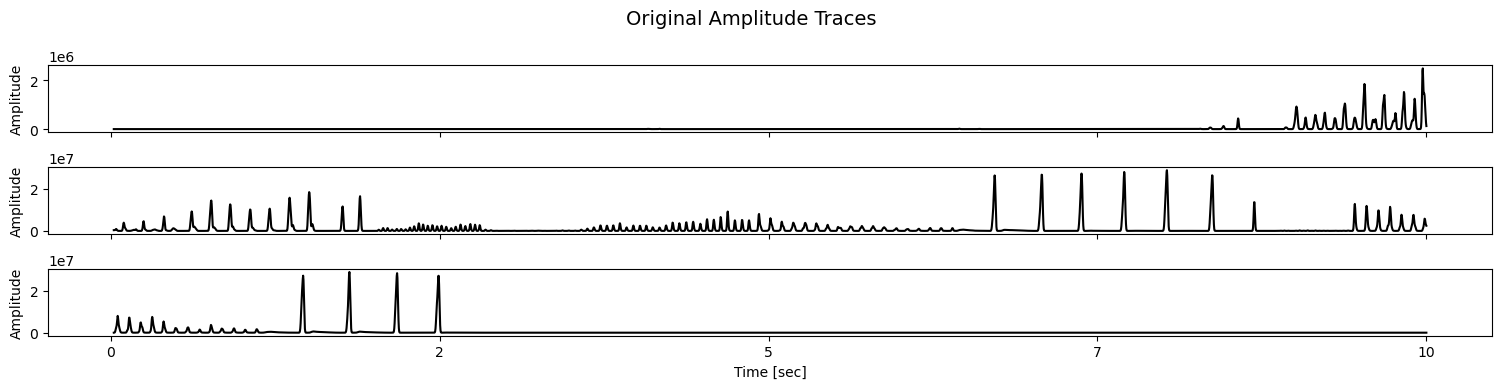

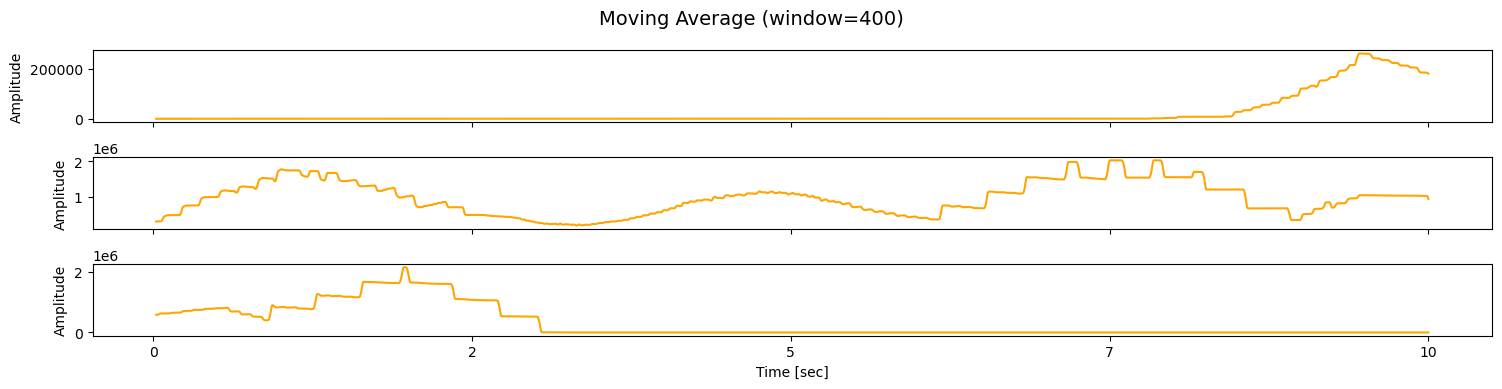

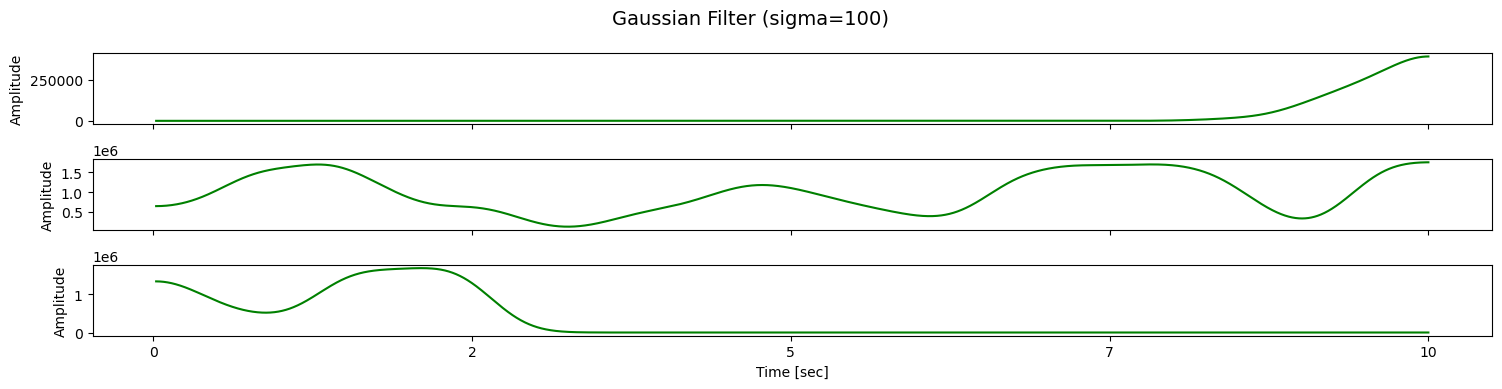

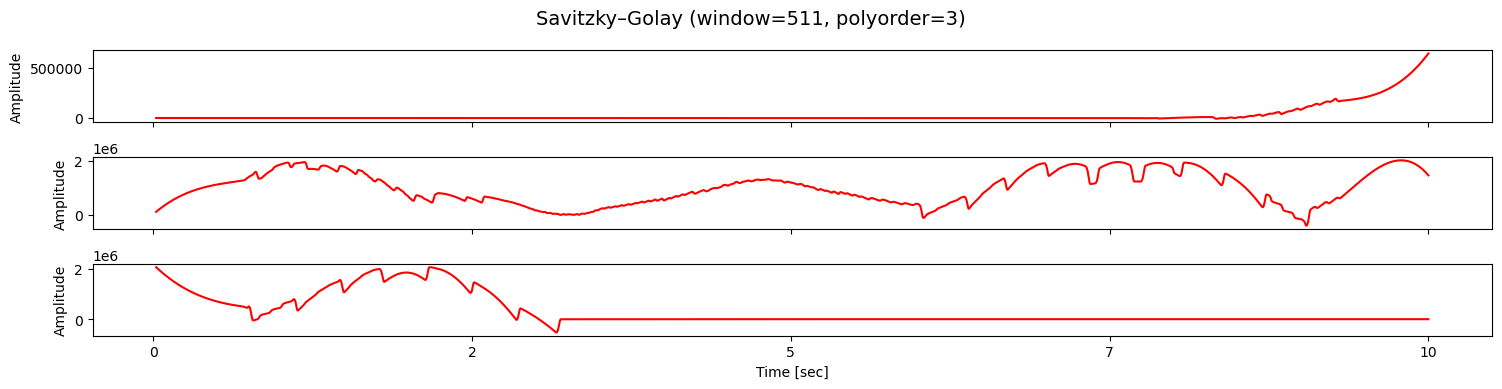

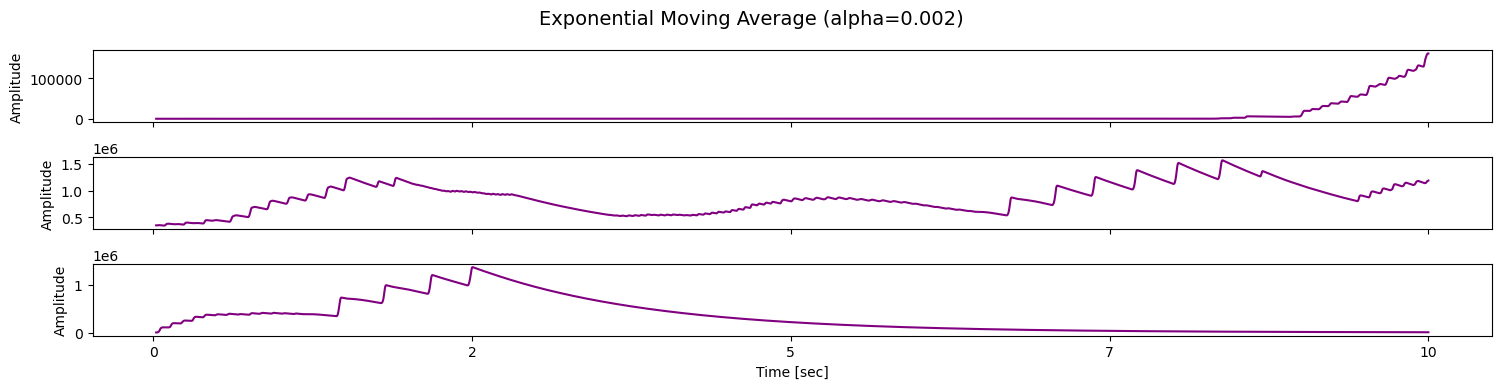

In [33]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt, savgol_filter
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

# === Smoothing Functions ===
def moving_average(x, window_size=400):  #started with 80, then increased
    smoothed = np.convolve(x, np.ones(window_size)/window_size, mode='same')
    return smoothed, f"Moving Average (window={window_size})"

def gaussian_smooth(x, sigma=100): #started with 10, larger sigma = more smoothing
    smoothed = gaussian_filter1d(x, sigma)
    return smoothed, f"Gaussian Filter (sigma={sigma})"

def savgol_smooth(x, window_length=511, polyorder=3): #started with 71. This value must be odd, increases smoothing
    smoothed = savgol_filter(x, window_length, polyorder)
    return smoothed, f"Savitzky–Golay (window={window_length}, polyorder={polyorder})"

def exponential_moving_average(x, alpha=0.002): # Started with 0.01. Lower alpha = more smoothing
    ema = np.zeros_like(x)
    ema[0] = x[0]
    for i in range(1, len(x)):
        ema[i] = alpha * x[i] + (1 - alpha) * ema[i-1]
    return ema, f"Exponential Moving Average (alpha={alpha})"

# === Get screen resolution in inches ===
def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100

width_inches, height_inches = get_screen_resolution()

# === Extract amplitude traces from file ===
def extract_amplitude_traces(file_path, segment_duration=10, low_cut=500, high_cut=8000):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        amplitude_traces = []
        time_vectors = []

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)

            amplitude_traces.append(amplitude_trace)
            time_vectors.append(t)

        return amplitude_traces, time_vectors

    except Exception as e:
        print(f"Error processing file: {e}")
        return [], []

# === Plot function: One figure per smoothing method ===
def plot_filtered_traces(amplitude_traces, time_vectors, filter_fn, color):
    num_segments = len(amplitude_traces)
    fig, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.4), sharex=True)
    if num_segments == 1:
        axs = [axs]

    # Get title from first trace
    _, title = filter_fn(amplitude_traces[0])

    for i in range(num_segments):
        signal = amplitude_traces[i]
        t = time_vectors[i]
        smoothed, _ = filter_fn(signal)
        axs[i].plot(t, smoothed, color=color)
        if i == num_segments - 1:
            axs[i].set_xlabel("Time [sec]")
            tick_positions = np.linspace(0, t[-1], 5)
            axs[i].set_xticks(tick_positions)
            axs[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
        else:
            axs[i].set_xticks([])
        axs[i].set_ylabel("Amplitude")

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

# === Run everything ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
amplitude_traces, time_vectors = extract_amplitude_traces(file_path)

if amplitude_traces:
    plot_filtered_traces(amplitude_traces, time_vectors, lambda x: (x, "Original Amplitude Traces"), 'black')
    plot_filtered_traces(amplitude_traces, time_vectors, moving_average, 'orange')
    plot_filtered_traces(amplitude_traces, time_vectors, gaussian_smooth, 'green')
    plot_filtered_traces(amplitude_traces, time_vectors, savgol_smooth, 'red')
    plot_filtered_traces(amplitude_traces, time_vectors, exponential_moving_average, 'purple')
else:
    print("No amplitude traces were extracted.")


# I like the Gaussian filter best. Next, let's apply a threshold to the smoothed amplitude trace. 

The screen resolution in inches is: 15.12x9.82


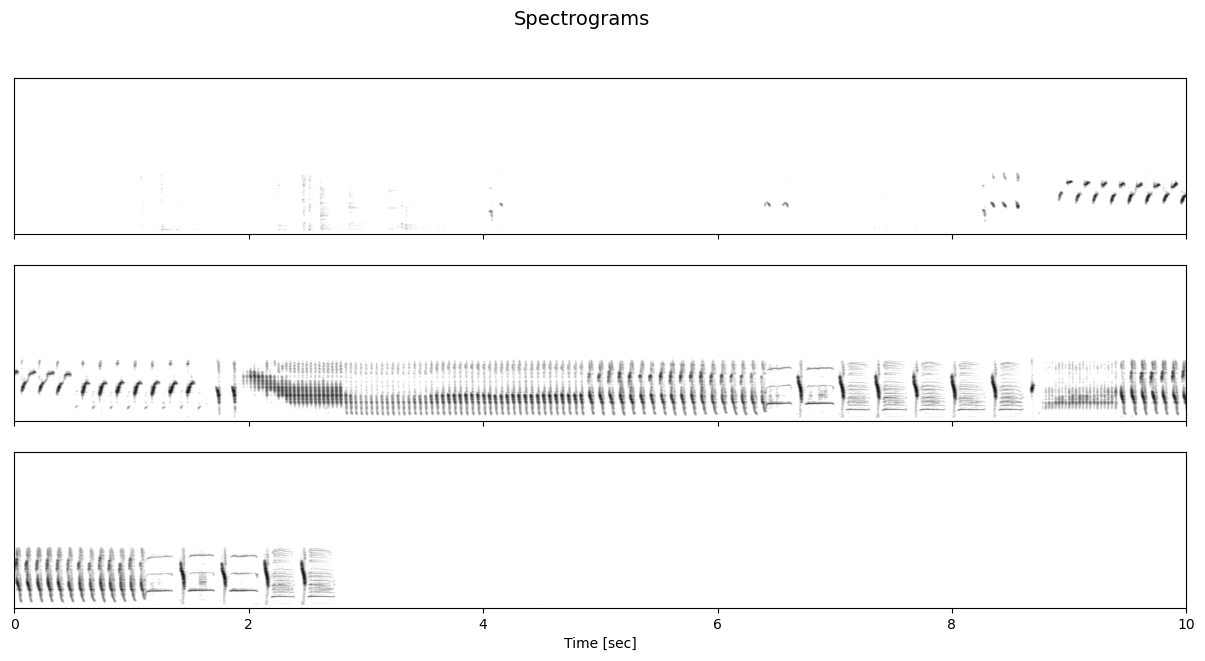

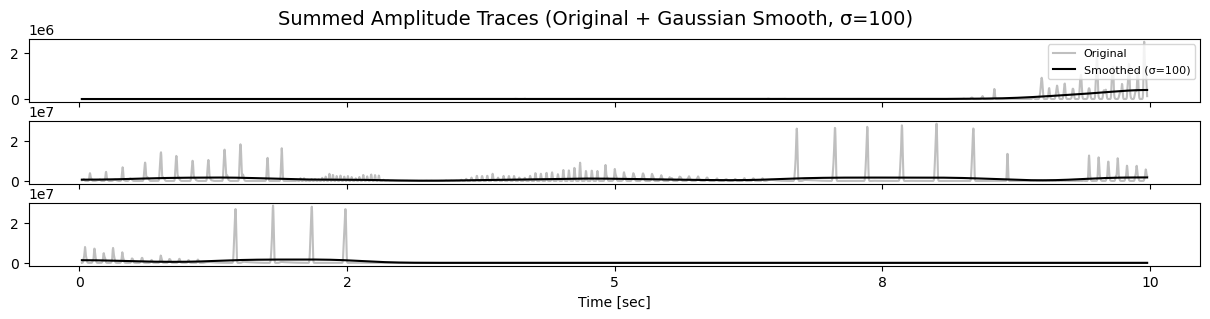

In [37]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, sigma=100):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            # Log normalize
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Plot spectrogram
            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Plot both raw and smoothed amplitude traces ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            smoothed_trace = gaussian_filter1d(amplitude_trace, sigma=sigma)

            axs_sum[i].plot(t, amplitude_trace, color='gray', alpha=0.5, label='Original')
            axs_sum[i].plot(t, smoothed_trace, color='black', label=f'Smoothed (σ={sigma})')

            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            if i == 0:
                axs_sum[i].legend(loc='upper right', fontsize=8)

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle(f'Summed Amplitude Traces (Original + Gaussian Smooth, σ={sigma})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, sigma=100)


The screen resolution in inches is: 15.12x9.82
Segment 1: 🎵 Song detected.
Segment 2: 🎵 Song detected.
Segment 3: 🎵 Song detected.


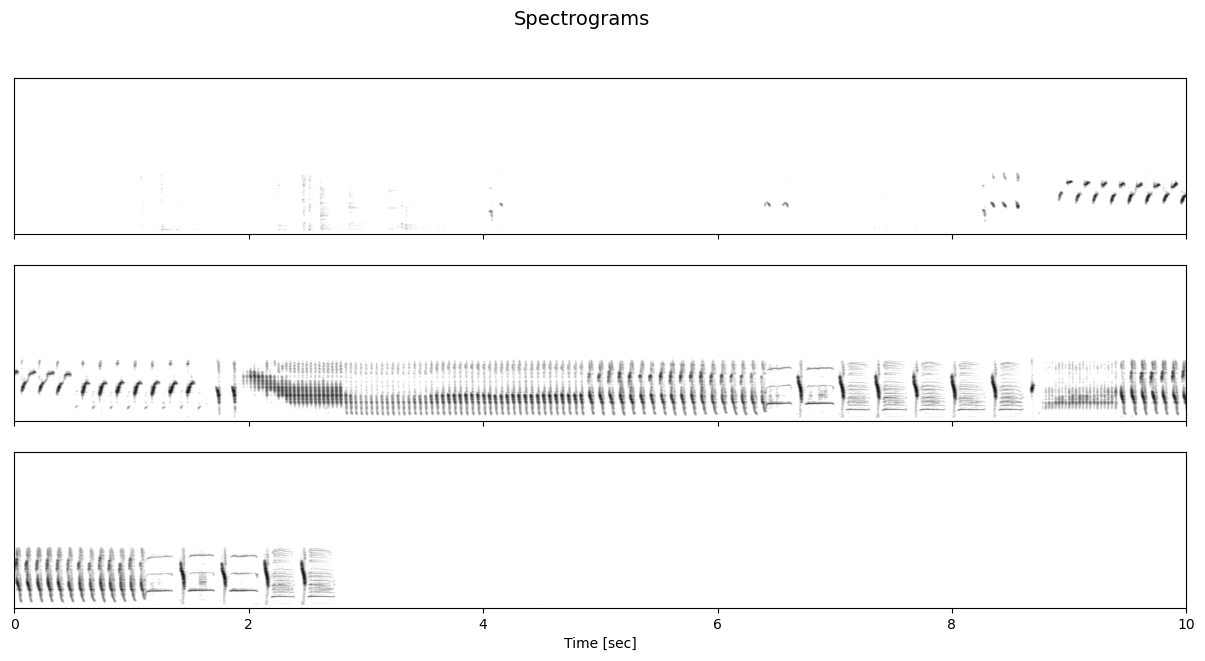

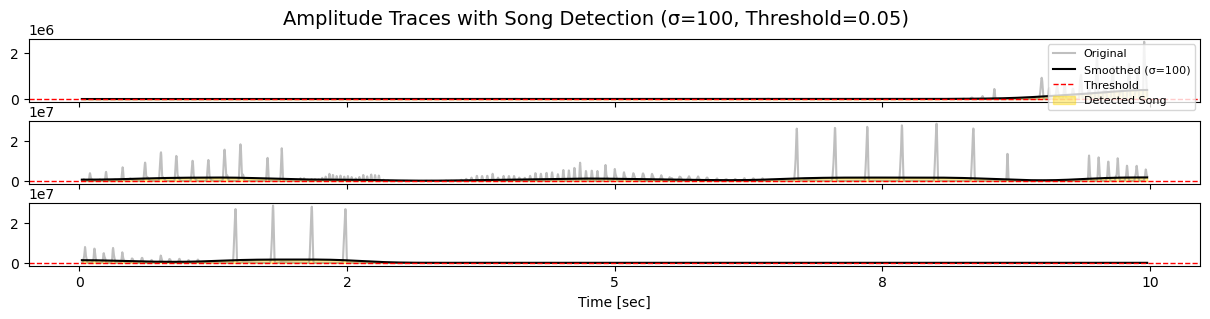

In [38]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, sigma=100, threshold=0.05):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            # Log normalize
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Plot spectrogram
            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Plot amplitude traces with smoothing, thresholding, and song detection ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            smoothed_trace = gaussian_filter1d(amplitude_trace, sigma=sigma)

            # Plot raw and smoothed
            axs_sum[i].plot(t, amplitude_trace, color='gray', alpha=0.5, label='Original')
            axs_sum[i].plot(t, smoothed_trace, color='black', label=f'Smoothed (σ={sigma})')
            axs_sum[i].axhline(threshold, color='red', linestyle='--', linewidth=1, label='Threshold')

            # Highlight song regions
            is_song = smoothed_trace > threshold
            axs_sum[i].fill_between(t, smoothed_trace, threshold, where=is_song, interpolate=True,
                                    color='gold', alpha=0.4, label='Detected Song' if i == 0 else None)

            # Optional: print if song was detected
            if np.any(is_song):
                print(f"Segment {i + 1}: 🎵 Song detected.")
            else:
                print(f"Segment {i + 1}: ⚪ No song detected.")

            # Labeling
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            if i == 0:
                axs_sum[i].legend(loc='upper right', fontsize=8)

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle(f'Amplitude Traces with Song Detection (σ={sigma}, Threshold={threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, sigma=100, threshold=0.05)


The screen resolution in inches is: 15.12x9.82
Segment 1: 🎵 Song detected.
Segment 2: 🎵 Song detected.
Segment 3: 🎵 Song detected.


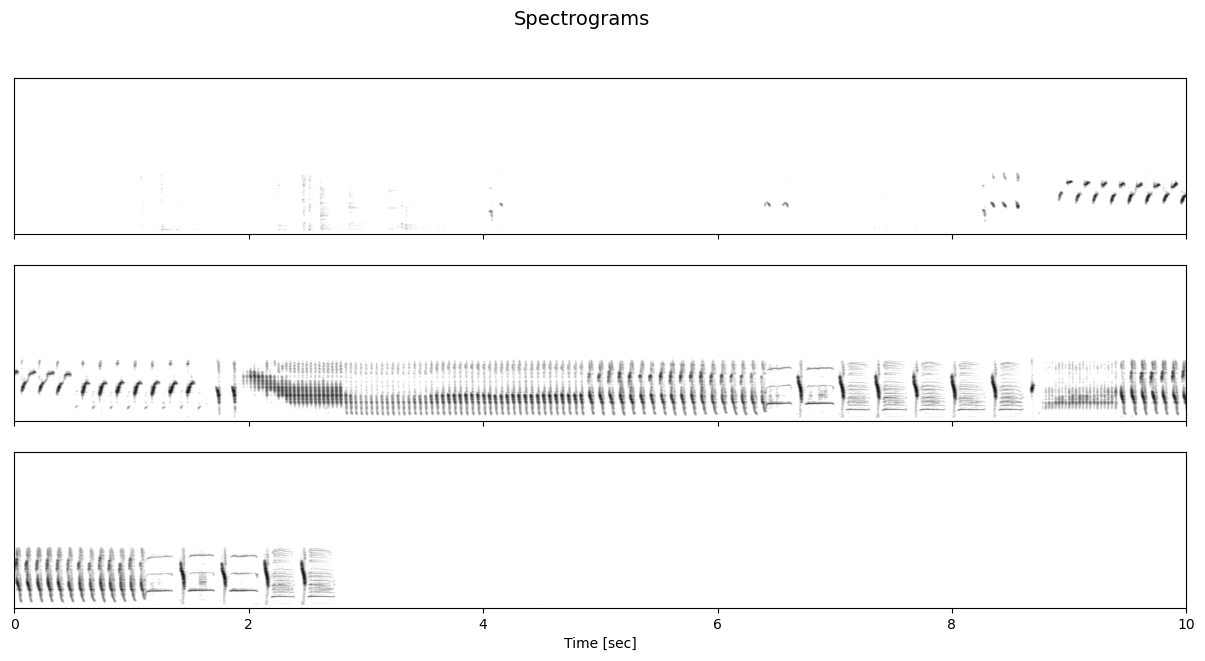

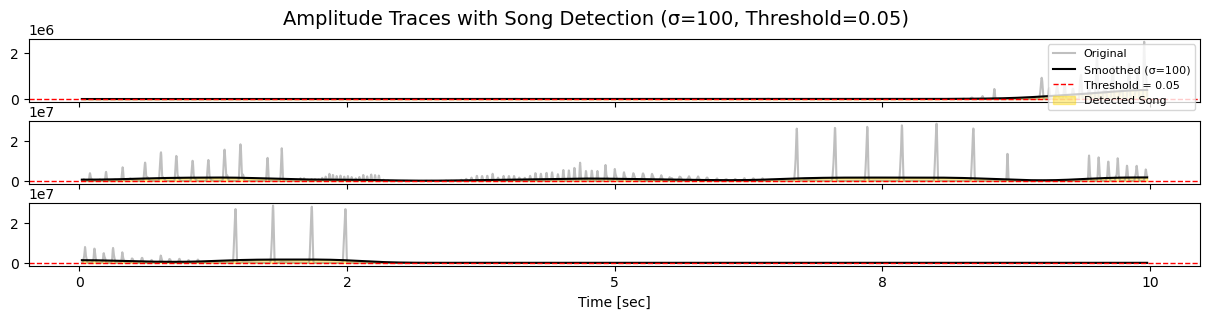

In [40]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, sigma=100, threshold=0.05):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        fig1, axs = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.7), sharex=True)
        fig2, axs_sum = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.3), sharex=True)
        plt.subplots_adjust(hspace=0.3)

        if num_segments == 1:
            axs = [axs]
            axs_sum = [axs_sum]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            # Log normalize
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Plot spectrogram
            axs[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                          extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs[i].set_ylabel('')
            axs[i].set_yticks([])
            if i == num_segments - 1:
                axs[i].set_xlabel('Time [sec]')

            # === Plot amplitude traces and highlight song ===
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            smoothed_trace = gaussian_filter1d(amplitude_trace, sigma=sigma)

            axs_sum[i].plot(t, amplitude_trace, color='gray', alpha=0.5, label='Original')
            axs_sum[i].plot(t, smoothed_trace, color='black', label=f'Smoothed (σ={sigma})')
            axs_sum[i].axhline(threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold = {threshold}')

            # Highlight song regions
            is_song = smoothed_trace > threshold
            axs_sum[i].fill_between(t, smoothed_trace, threshold, where=is_song, interpolate=True,
                                    color='gold', alpha=0.4, label='Detected Song' if i == 0 else None)

            # Optional output
            if np.any(is_song):
                print(f"Segment {i + 1}: 🎵 Song detected.")
            else:
                print(f"Segment {i + 1}: ⚪ No song detected.")

            # Axis formatting
            if i == num_segments - 1:
                axs_sum[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_sum[i].set_xticks(tick_positions)
                axs_sum[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_sum[i].set_xticks([])

            if i == 0:
                axs_sum[i].legend(loc='upper right', fontsize=8)

        fig1.suptitle('Spectrograms', fontsize=14)
        fig2.suptitle(f'Amplitude Traces with Song Detection (σ={sigma}, Threshold={threshold})', fontsize=14)
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, sigma=100, threshold=0.05)


The screen resolution in inches is: 15.12x9.82
Segment 1: 🎵 Song detected.
Segment 2: 🎵 Song detected.
Segment 3: 🎵 Song detected.


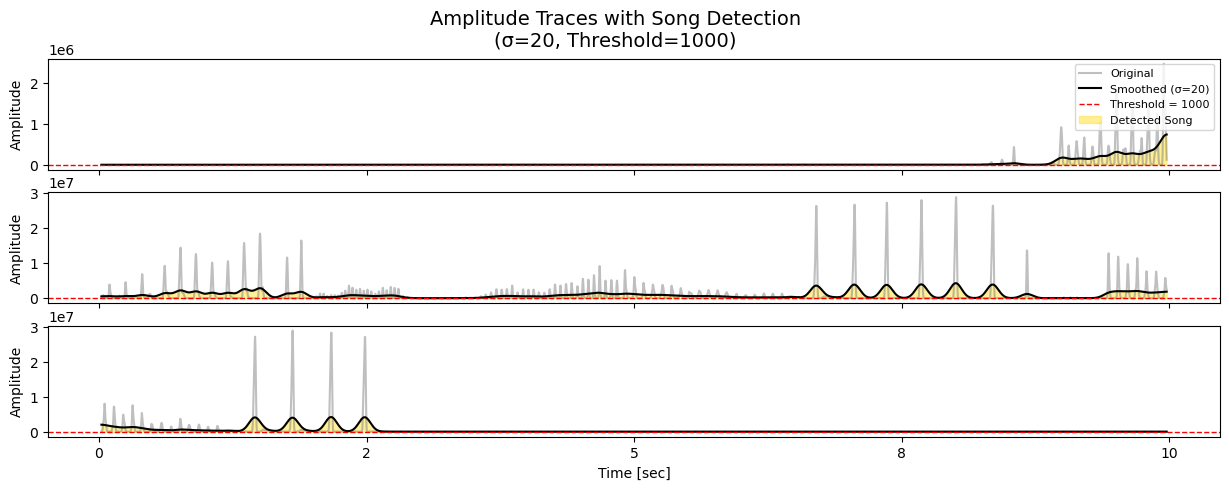

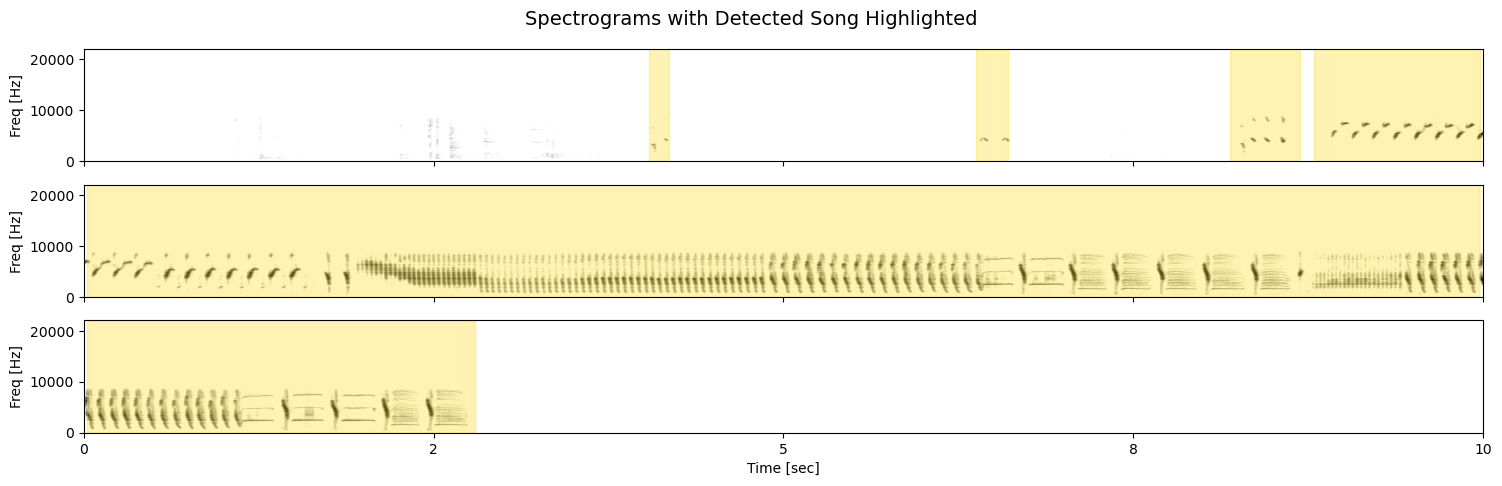

In [1]:
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, windows, ellip, filtfilt
from scipy.ndimage import gaussian_filter1d
import matplotlib.pyplot as plt
import tkinter as tk

def get_screen_resolution():
    root = tk.Tk()
    root.withdraw()
    screen_width = root.winfo_screenwidth()
    screen_height = root.winfo_screenheight()
    root.destroy()
    return screen_width / 100, screen_height / 100  # inches (assuming 100 dpi)

width_inches, height_inches = get_screen_resolution()
print(f"The screen resolution in inches is: {width_inches}x{height_inches}")

def plot_spectrograms_by_segment(file_path, segment_duration=10, low_cut=500, high_cut=8000, sigma=100, threshold=0.05):
    try:
        samplerate, data = wavfile.read(file_path)
        if data.ndim > 1:
            data = data.mean(axis=1)

        # Bandpass filter
        nyquist = samplerate / 2
        wp = [low_cut / nyquist, high_cut / nyquist]
        b, a = ellip(5, 0.2, 40, wp, btype='band')
        data = filtfilt(b, a, data)

        duration_seconds = data.shape[0] / samplerate
        segment_length_samples = int(segment_duration * samplerate)
        num_segments = int(np.ceil(duration_seconds / segment_duration))

        # === Figure 1: Amplitude Traces with Song Detection ===
        fig1, axs_amp = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        if num_segments == 1:
            axs_amp = [axs_amp]

        # === Figure 2: Spectrograms with Song Highlight ===
        fig2, axs_spec = plt.subplots(num_segments, 1, figsize=(width_inches, height_inches * 0.5), sharex=True)
        if num_segments == 1:
            axs_spec = [axs_spec]

        for i in range(num_segments):
            start_sample = i * segment_length_samples
            end_sample = start_sample + segment_length_samples

            if end_sample > data.shape[0]:
                segment_data = np.zeros(segment_length_samples, dtype=data.dtype)
                segment_data[:data.shape[0] - start_sample] = data[start_sample:]
            else:
                segment_data = data[start_sample:end_sample]

            # Spectrogram
            f, t, Sxx = spectrogram(
                segment_data,
                fs=samplerate,
                window=windows.gaussian(2048, std=2048/8),
                nperseg=2048,
                noverlap=(2048 - 119)
            )

            # Normalize Sxx
            Sxx_log = 10 * np.log10(Sxx + np.finfo(float).eps)
            Sxx_log_clipped = np.clip(Sxx_log, a_min=-2, a_max=None)
            Sxx_log_normalized = (Sxx_log_clipped - np.min(Sxx_log_clipped)) / (np.max(Sxx_log_clipped) - np.min(Sxx_log_clipped))

            # Amplitude trace and smoothing
            freq_mask = (f >= low_cut) & (f <= high_cut)
            Sxx_band = Sxx[freq_mask, :]
            amplitude_trace = np.sum(Sxx_band, axis=0)
            smoothed_trace = gaussian_filter1d(amplitude_trace, sigma=sigma)
            is_song = smoothed_trace > threshold

            # === Plot in Figure 1: Amplitude Traces ===
            axs_amp[i].plot(t, amplitude_trace, color='gray', alpha=0.5, label='Original')
            axs_amp[i].plot(t, smoothed_trace, color='black', label=f'Smoothed (σ={sigma})')
            axs_amp[i].axhline(threshold, color='red', linestyle='--', linewidth=1, label=f'Threshold = {threshold}')
            axs_amp[i].fill_between(t, smoothed_trace, threshold, where=is_song, interpolate=True,
                                    color='gold', alpha=0.4, label='Detected Song' if i == 0 else None)
            axs_amp[i].set_ylabel('Amplitude')

            if i == 0:
                axs_amp[i].legend(loc='upper right', fontsize=8)
            if i == num_segments - 1:
                axs_amp[i].set_xlabel('Time [sec]')
                tick_positions = np.linspace(0, segment_duration, 5)
                axs_amp[i].set_xticks(tick_positions)
                axs_amp[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_amp[i].set_xticks([])

            # Print song detection status
            if np.any(is_song):
                print(f"Segment {i + 1}: 🎵 Song detected.")
            else:
                print(f"Segment {i + 1}: ⚪ No song detected.")

            # === Plot in Figure 2: Spectrograms ===
            axs_spec[i].imshow(Sxx_log_normalized, aspect='auto', origin='lower',
                               extent=[0, segment_duration, f.min(), f.max()], cmap='binary')
            axs_spec[i].fill_between(t, f.min(), f.max(), where=is_song, color='gold', alpha=0.3)
            axs_spec[i].set_ylabel('Freq [Hz]')

            if i == num_segments - 1:
                axs_spec[i].set_xlabel('Time [sec]')
                axs_spec[i].set_xticks(tick_positions)
                axs_spec[i].set_xticklabels([f"{val:.0f}" for val in tick_positions])
            else:
                axs_spec[i].set_xticks([])

        fig1.suptitle(f'Amplitude Traces with Song Detection\n(σ={sigma}, Threshold={threshold})', fontsize=14)
        fig2.suptitle('Spectrograms with Detected Song Highlighted', fontsize=14)

        plt.tight_layout()
        plt.show()

    except ValueError as e:
        print(f"Error processing {file_path}: {e}")

# === RUN THIS SECTION ===
file_path = '/Users/mirandahulsey-vincent/Documents/allPythonCode/BYOD_class/data_inputs/USA5288_45390.29509926_4_8_8_11_49.wav'
plot_spectrograms_by_segment(file_path, sigma=20, threshold=1000)
